In [1]:
import hashlib
import os
import tarfile
import zipfile
import requests

#@save
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [2]:
def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [3]:
def download_extract(name, folder=None):  #@save
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #@save
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

In [4]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [5]:
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [6]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [7]:
train_data.shape

(1460, 81)

In [8]:
test_data.shape

(1459, 80)

In [9]:
# 查看前四行，一二三   倒数一二三列 数据
print(train_data.iloc[:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [10]:
print(test_data.iloc[: 4, [0, 1, 2, 3, -3, -2, -1]])

     Id  MSSubClass MSZoning  LotFrontage  YrSold SaleType SaleCondition
0  1461          20       RH         80.0    2010       WD        Normal
1  1462          20       RL         81.0    2010       WD        Normal
2  1463          60       RL         74.0    2010       WD        Normal
3  1464          60       RL         78.0    2010       WD        Normal


In [11]:
# 删除训练数据的第一列(ID)和最后一列(销售价格)，测试数据的第一列(ID)，然后将其连起来
all_features = pd.concat([train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]])

In [12]:
all_features.shape

(2919, 79)

### 数据预处理

In [16]:
# 将所有缺失的值替换为相应特征的平均值, 然后将所有特征放在同一个尺度上，使用零均值和单位方差来标准化数据
#   != object 就是数值, 找到数值的那些列
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(lambda x: (x - x.mean()) / x.std())
# 有值的变化为均值为0 方差为1 ，没值的填充为0  （此时的0就是均值）
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [27]:
# 使用 one-hot 编码对其他值进行处理， 比如说这一列的值有五种，就将其分为五列，使用 0-1 表示
all_features = pd.get_dummies(all_features, dummy_na=True)

In [29]:
all_features.shape

(2919, 331)

In [33]:
n_train = train_data.shape[0]  # 训练样本数
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32) # 训练集
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32) # 测试集
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32) # 标签(房价)

In [34]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features, 1))
    return net

### 一样的预测偏差在不同的地区差别可能会很大，采用相对误差而不是绝对误差
### 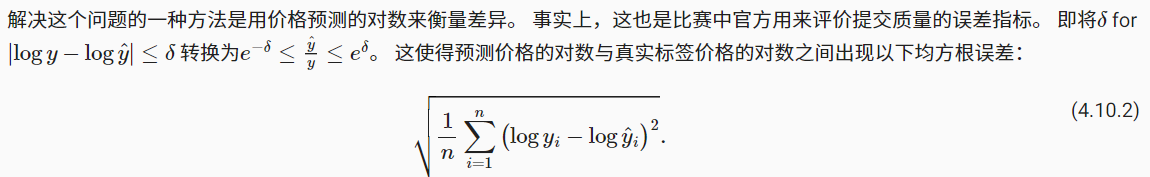

In [37]:
def log_rmse(net, features, labels):
    # 将数值范围控制在 1 - inf 以内
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

In [40]:
def train(net, train_features, train_labels, test_features, test_labels, 
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 使用 Adam 优化算法， SGD 对 lr 太敏感了
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
        
    return train_ls, test_ls
            

In [61]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        # 将训练集分为 k 块， 其中第 j 块的索引
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            # dim = 0 竖直拼接
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [64]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls], 
                     xlabel='epoch', ylabel='rmse', 
                     xlim=[1, num_epochs], legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse {float(train_ls[-1]):f}, '
              f'验证log rmse {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k
    

折1，训练log rmse 0.169217, 验证log rmse 0.155856
折2，训练log rmse 0.162577, 验证log rmse 0.190849
折3，训练log rmse 0.163795, 验证log rmse 0.168158
折4，训练log rmse 0.168210, 验证log rmse 0.154866
折5，训练log rmse 0.162956, 验证log rmse 0.182735
5-折验证：平均训练log rmse：0.165351, 平均验证log rmse：0.170493


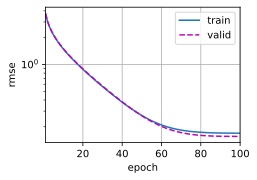

In [66]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)

print(f'{k}-折验证：平均训练log rmse：{float(train_l):f}, ' f'平均验证log rmse：{float(valid_l):f}')

In [69]:
def train_and_pred(train_features, test_features, train_labels, test_data, 
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None, 
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], 
            xlabel='epoch', ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    
    preds = net(test_features).detach().numpy()
    
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

训练log rmse：0.162522


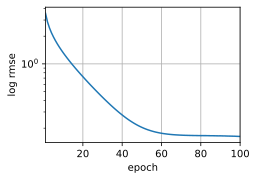

In [70]:
train_and_pred(train_features, test_features, train_labels, test_data,
              num_epochs, lr, weight_decay, batch_size)

In [71]:
test_data.shape

(1459, 81)

In [74]:
print(test_data.iloc[:4,[ 0, 1, 2, 3, -3, -2, -1]])

     Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  \
0  1461          20       RH         80.0       WD        Normal   
1  1462          20       RL         81.0       WD        Normal   
2  1463          60       RL         74.0       WD        Normal   
3  1464          60       RL         78.0       WD        Normal   

       SalePrice  
0  119318.359375  
1  154448.015625  
2  198646.921875  
3  217125.546875  
